In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.model_selection import StratifiedKFold

RANDOM_VARIABLE = 42

In [2]:
data = pd.read_csv('income.csv')
data_test = pd.read_csv('income_test.csv')

# Convert target variable to 0 and 1
data["income"] = data["income"].map({ "<=50K": 0, ">50K": 1 })
data_test["income"] = data_test["income"].map({ "<=50K": 0, ">50K": 1 })

# Create X and y
X_train = data.drop(["income"],axis=1)
y_train = data['income'].values
X_test = data_test.drop(["income"],axis=1)
y_test = data_test['income'].values

In [3]:
# Data exploration
X_train.info()
X_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15315 entries, 0 to 15314
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          -------

In [4]:
# Separate attributes of type int and of type object
int_X_train = X_train.select_dtypes(include=['int64']).copy()
obj_X_train = X_train.select_dtypes(include=['object']).copy()

int_X_test = X_test.select_dtypes(include=['int64']).copy()
obj_X_test = X_test.select_dtypes(include=['object']).copy()


In [5]:
# Imputation of missing values with a string "missing"
imputer1 = SimpleImputer(strategy='constant', fill_value="missing")


In [6]:
# Apply simple imputation only in obj_X_train because this is where the missing values are
obj_X_train = pd.DataFrame(data= imputer1.fit_transform(obj_X_train), index=obj_X_train.index, columns=obj_X_train.columns)

In [7]:
# Encoders to use
labelEncoder = preprocessing.LabelEncoder()
encoder = OneHotEncoder()
oneHotEncoderFlag = True


In [8]:
# Label Encode the categorical attributes and then turn the missing encoded values into NaN again
missing = np.array(["missing"])
for i in obj_X_train.columns:
    flag = missing[0] in list(obj_X_train[i])  # flag indicates the presence of missing values in the column
    obj_X_train[i] = labelEncoder.fit_transform(obj_X_train[i])
    obj_X_test[i] = labelEncoder.transform(obj_X_test[i])
    if flag: # search for encoded string missing and replace it with NaN
        obj_X_train[i] = obj_X_train[i].replace(labelEncoder.transform(missing),np.nan)
        
obj_X_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   workclass       30725 non-null  float64
 1   education       32561 non-null  int32  
 2   marital-status  32561 non-null  int32  
 3   occupation      30718 non-null  float64
 4   relationship    32561 non-null  int32  
 5   race            32561 non-null  int32  
 6   sex             32561 non-null  int32  
dtypes: float64(2), int32(5)
memory usage: 1.1 MB


In [9]:
## Now that all attributes are numerical, many imputation methods can be applied
imputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imputer2 = KNNImputer(n_neighbors=10)
# imputer2 = IterativeImputer(max_iter=15, random_state=RANDOM_VARIABLE)


In [10]:
# Try also one hot encoding
if oneHotEncoderFlag:
    X_train = pd.concat([obj_X_train, int_X_train], axis=1)
 
    X_train = pd.DataFrame(data = imputer2.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    obj_X_train = X_train.drop(columns=int_X_train.columns)
                               
    obj_X_train_1hot = encoder.fit_transform(obj_X_train)
    obj_X_test_1hot = encoder.transform(obj_X_test)
                               
    obj_X_train_1hot = obj_X_train_1hot.toarray()
    obj_X_test_1hot = obj_X_test_1hot.toarray()
                               
    int_X_train = int_X_train.to_numpy()
    int_X_test = int_X_test.to_numpy()
    
    # recreate X_train and X_test
    X_train = np.hstack((obj_X_train_1hot,int_X_train))
    X_test = np.hstack((obj_X_test_1hot,int_X_test))
else:
    # recreate X_train and X_test
    X_train = pd.concat([obj_X_train, int_X_train], axis=1)
    X_test = pd.concat([obj_X_test, int_X_test], axis=1)
    X_train = pd.DataFrame(data = imputer2.fit_transform(X_train))  

In [11]:
# Construct pipeline
pipe = Pipeline([('scale', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=RANDOM_VARIABLE))])

In [12]:
# Set grid search params
grid_params = [{'clf__criterion': ['gini', 'entropy'],
'clf__min_samples_leaf':  [5, 10, 15, 20, 25, 30, 40, 50],
'clf__max_depth': [3, 5, 7, 8, 9, 10, 12, 15]}]


In [13]:
# Construct grid search
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_VARIABLE)
gs = GridSearchCV(estimator=pipe,param_grid=grid_params,scoring='accuracy',cv=cv, n_jobs=3, verbose=2) 

In [14]:
# Fit using grid search
gs.fit(X_train, y_train)

print('Best score (evaluation accuracy): {}'.format(gs.best_score_))
print('Best parametes: {}'.format(gs.best_params_))


Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Best score (evaluation accuracy): 0.8592178705626663
Best parametes: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 15}


In [15]:
y_pred = gs.predict(X_test)
accScore = accuracy_score(y_test,y_pred)
fScore = f1_score(y_test, y_pred)
print(fScore)
print(accScore)


0.6711874623267029
0.8575253019915116


In [16]:
#-----------------------------------------------------------------------------------------------------------------------

In [17]:
# Load Data
columns = ['age','fnlwgt','education_num','hours-per-week',"capital-loss","capital-gain","income"]
data = pd.read_csv('income.csv',usecols=columns)
data_test = pd.read_csv('income_test.csv',usecols=columns)
# Convert target variable to 0 and 1
data["income"] = data["income"].map({ "<=50K": 0, ">50K": 1 })
data_test["income"] = data_test["income"].map({ "<=50K": 0, ">50K": 1 })
# Create X and y
X_train = data.drop(["income"],axis=1)
y_train = data['income'].values
X_test = data_test.drop(["income"],axis=1)
y_test = data_test['income'].values
# Classifier
classifier = DecisionTreeClassifier(min_samples_leaf=4)

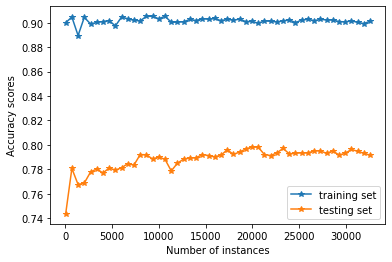

In [19]:
import matplotlib.pyplot as plt
# Draw a learning curve for the classifer for the train and test set loaded above
def learning_curve(classifier,X_train,y_train,X_test,y_test,train_sizes): 
    
    acc_score_train = []
    acc_score_test = []
    for i in train_sizes:
        
        X_train_new = X_train.iloc[:i,:]
        y_train_new = y_train[0:i]
        
        classifier.fit(X_train_new, y_train_new)
        
        y_pred_train = classifier.predict(X_train_new)
        y_pred_test = classifier.predict(X_test)
        
        acc_score_train.append(accuracy_score(y_train_new, y_pred_train))
        acc_score_test.append( accuracy_score(y_test, y_pred_test))
        
    # Plot learning curve    
    plt.plot(train_sizes,acc_score_train, '-*', label="training set")
    plt.plot(train_sizes,acc_score_test, '-*', label="testing set")
    plt.ylabel('Accuracy scores')
    plt.xlabel('Number of instances')
    plt.legend(loc="best")
    plt.show()   
    
    return acc_score_train, acc_score_test

# Call learning curve
lengthX = X_train.shape[0]
train_sizes = np.linspace(50,lengthX,num=50).astype(int)
acc_score_train, acc_score_test = learning_curve(classifier,X_train,y_train,X_test,y_test,train_sizes)


In [20]:
# Observations from the performance learning curve:

# -Training score (accuracy) is at its maximum regardless of training examples. This shows severe overfitting.

# -Testing score slightly increases.

# -There is a huge gap between testing score and training score which indicates high variance scenario (again, this means overfitting).

# Solutions - Dealing with overfitting: make the model not to fit as much to the data by changing the hyper parameters :

# -Limiting the maximum depth or number of leaves of the tree

# -Requiring a minimum number of points in a node to keep splitting it

Initial Model

DecisionTreeClassifier scores with min_samples_leaf = 4:
Accuracy = 0.7901
F1 = 0.5319

Tree max depth = 39



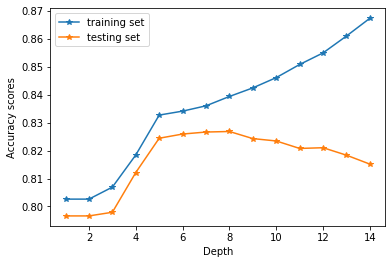

Second Model

DecisionTreeClassifier scores with min_samples_leaf = 4 and max_depth = 8:
Accuracy = 0.8276
F1 = 0.5466



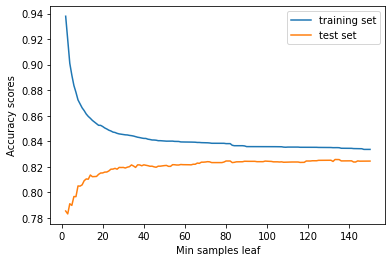

Third Model
DecisionTreeClassifier scores with min_samples_leaf = 7:
Accuracy = 0.7966
F1 = 0.5413

Fourth Model
DecisionTreeClassifier scores max_depth=8 and with min_samples_leaf = 7:
Accuracy = 0.8278
F1 = 0.5479

Fifth Model
DecisionTreeClassifier scores max_depth=8:
Accuracy = 0.8268
F1 = 0.5445

Final Score
[0.8278158667972576, 0.5479170238299331]


In [21]:
# Solution

# Accuracy and F1-score when implementing the initial decision tree model from 3.1 (DecisionTreeClassifier(min_samples_leaf=4))
classifier = DecisionTreeClassifier(min_samples_leaf=4)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Initial Model\n")
print("DecisionTreeClassifier scores with min_samples_leaf = 4:")
print(f"Accuracy = {acc:.4f}")
print(f"F1 = {f1:.4f}\n")
print(f"Tree max depth = {classifier.tree_.max_depth}\n")

################################################################################################################################

# Now let's try limit the maximum depth of the tree (keeping min_samples_leaf=4)
acc_train = []
acc_test = []
for d in range(1,15,1):
    tree = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_VARIABLE)
    tree.fit(X_train, y_train)
    acc_train = np.append(acc_train,tree.score(X_train, y_train))
    acc_test = np.append(acc_test,tree.score(X_test, y_test))

plt.figure(num=1)
plt.plot(range(1,15,1),acc_train, '-*', label="training set")
plt.plot(range(1,15,1),acc_test, '-*', label="testing set")
plt.ylabel('Accuracy scores')
plt.xlabel('Depth')
plt.legend(loc="best")
plt.show()

# As we can see from figure 1, the testing accuracy starts decreasing after max_depth = 8. So I will choose this value
# for the max_depth parameter to see what will happen to the scores of the model.

# Accuracy and F1-score of the decision tree model from 3.1 (DecisionTreeClassifier(min_samples_leaf=4)) with max_depth = 8
classifier2 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=4)
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_test)
acc_2 = accuracy_score(y_test, y_pred)
f1_2 = f1_score(y_test, y_pred)
print("Second Model\n")
print("DecisionTreeClassifier scores with min_samples_leaf = 4 and max_depth = 8:")
print(f"Accuracy = {acc_2:.4f}")
print(f"F1 = {f1_2:.4f}\n")

################################################################################################################################

# Requiring a minimum number of points in a node to keep splitting it
accTrain = []
accTest = []
accVal = []
lnS = []
for ln in range(2,151,1):
    lnS.append(ln)
    tree = DecisionTreeClassifier(min_samples_leaf=ln, random_state=42)
    tree.fit(X_train, y_train)
    trainAc = tree.score(X_train, y_train)
    accTrain.append(trainAc)
    testAc = tree.score(X_test, y_test)
    accTest.append(testAc)
    
plt.figure(num=2)    
plt.plot(lnS,accTrain, label="training set")
plt.plot(lnS,accTest, label="test set")
plt.ylabel('Accuracy scores')
plt.xlabel('Min samples leaf')
plt.legend(loc="best")
plt.show()

# As we can see from figure 2 the training and testing accuracies start slowly reaching a plateau at around 40-50
# min_sample_leafs. Generally we want high training and testing accuracies without though an overfitting appearence. 
# So, based on the diagramm and on the above, I will try min_samples_leaf values 5 - 10.

# Accuracy and F1-score when the decision tree model with min_samples_leaf = 7
classifier3 = DecisionTreeClassifier(min_samples_leaf=7)
classifier3.fit(X_train, y_train)
y_pred = classifier3.predict(X_test)
acc_3 = accuracy_score(y_test, y_pred)
f1_3 = f1_score(y_test, y_pred)
print("Third Model")
print("DecisionTreeClassifier scores with min_samples_leaf = 7:")
print(f"Accuracy = {acc_3:.4f}")
print(f"F1 = {f1_3:.4f}\n")

# min_samples_leaf = 7 gave the best scores

################################################################################################################################

# Let's try max_depth = 8 and min_samples_leaf = 7
classifier4 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=7)
classifier4.fit(X_train, y_train)
y_pred = classifier4.predict(X_test)
acc_4 = accuracy_score(y_test, y_pred)
f1_4 = f1_score(y_test, y_pred)
print("Fourth Model")
print("DecisionTreeClassifier scores max_depth=8 and with min_samples_leaf = 7:")
print(f"Accuracy = {acc_4:.4f}")
print(f"F1 = {f1_4:.4f}\n")
# Results better from all the above

################################################################################################################################

# Let's try only limiting the max_depth to 8 and give no value to parameter min_samples_leaf
classifier5 = DecisionTreeClassifier(max_depth=8)
classifier5.fit(X_train, y_train)
y_pred = classifier5.predict(X_test)
acc_5 = accuracy_score(y_test, y_pred)
f1_5 = f1_score(y_test, y_pred)
print("Fifth Model")
print("DecisionTreeClassifier scores max_depth=8:")
print(f"Accuracy = {acc_5:.4f}")
print(f"F1 = {f1_5:.4f}\n")

################################################################################################################################

# So it's obvious that limiting the max_depth parameter and increasing a bit the min_samples_leaf parameter to 7 
# gives the best scores.

final_score = [acc_4,f1_4]
print("Final Score")
print(final_score)